Adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Colab drive

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # 
    %cd drive/My Drive/1_OptML_project 
    PATH = './repo/'
else :
    PATH = './'

# Initialization

In [9]:
%matplotlib inline

In [10]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 123

#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


Here we use the Celeb-A Faces dataset which can be downloaded at the linked site, or in Google Drive. The dataset will download as a file named img_align_celeba.zip. Once downloaded, create a directory named celeba and extract the zip file into that directory. Then, set the dataroot input for this notebook to the celeba directory you just created.



In [4]:
# Root directory for dataset
dataroot = PATH + "data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 2 # 20 yielded good results

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Data

In [5]:
import torchvision

In [6]:
# there are problems with downloading CelebA
# see https://stackoverflow.com/questions/65528568/how-do-i-load-the-celeba-dataset-on-google-colab-using-torch-vision-without-ru

In [7]:

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Why do we use these means and stds ? 
)])


dataset = torchvision.datasets.CIFAR10(dataroot, download=True, 
                                       train=True,  transform=transform)

# DATASET = 'MNIST' #'Cifar10

# dataset = torchvision.datasets.MNIST(dataroot, download=True, 
#                                        train=True,  transform=transform)
# transform = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.CenterCrop(image_size),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Why do we use these means and stds ? 
# )])


Files already downloaded and verified


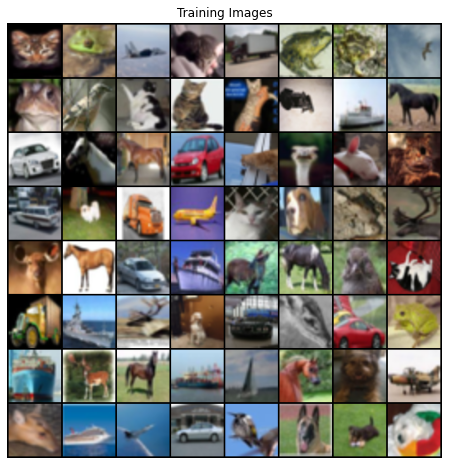

In [8]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
# dataset = dset.ImageFolder(root=dataroot,
#                           transform=transforms.Compose([
#                               transforms.Resize(image_size),
#                               transforms.CenterCrop(image_size),
#                               transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                           ]))


# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig(PATH + 'img/training_images', format="png",dpi=400)

# Model

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Instantiation

In [ ]:
def init_netG(ngpu, device):
    # Create the generator
    netG = Generator(ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.02.
    netG.apply(weights_init)

    # Print the model
    print(netG)
    return netG

In [ ]:
def init_netD(ngpu, device):
    # Create the Discriminator
    netD = Discriminator(ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))
        
    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    netD.apply(weights_init)

    # Print the model
    print(netD)
    return netD

In [ ]:
netG = init_netG(ngpu, device)
netD = init_netD(ngpu, device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
Dis

# Training

In [ ]:
def init_optimizers(netD, netG, lr, beta1, nz, device):
    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    return criterion, fixed_noise, real_label, fake_label, optimizerD, optimizerG

In [ ]:
criterion, fixed_noise, real_label, fake_label, optimizerD, optimizerG = init_optimizers(netD, netG, lr, beta1, nz, device)

In [ ]:
def discriminator_step(netD, netG, data, device, real_label, fake_label):
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device) # changing this may improve performace ( .to )
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = netD(real_cpu).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()  # changing this may improve performace ( .item )

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()
    return D_x, D_G_z1, errD, label, fake


def generator_step(netD, netG, label, fake, real_label):
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()
    return D_G_z2, errG
    

In [ ]:
# Training Loop

# Lists to keep track of progress
def train(netD, netG, device, real_label, fake_label, dataloader, num_epochs, fixed_noise):
    
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            D_x, D_G_z1, errD, label, fake = discriminator_step(netD, netG, data, device, real_label, fake_label)

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            D_G_z2, errG = generator_step(netD, netG, label, fake, real_label)
            
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                
            iters += 1

    stats = {
      'img_list' : img_list,
      'G_losses' : G_losses,
      'D_losses' : D_losses  
    }

    return stats

In [ ]:
stats = train(netD, netG, device, real_label, fake_label, dataloader, num_epochs, fixed_noise)

Starting Training Loop...
[0/2][0/391]	Loss_D: 1.5158	Loss_G: 2.4519	D(x): 0.4848	D(G(z)): 0.4774 / 0.1068
[0/2][50/391]	Loss_D: 0.0897	Loss_G: 7.7420	D(x): 0.9597	D(G(z)): 0.0454 / 0.0006
[0/2][100/391]	Loss_D: 0.0275	Loss_G: 7.9140	D(x): 0.9880	D(G(z)): 0.0151 / 0.0004
[0/2][150/391]	Loss_D: 0.0197	Loss_G: 8.7454	D(x): 0.9821	D(G(z)): 0.0007 / 0.0002
[0/2][200/391]	Loss_D: 0.1043	Loss_G: 8.8596	D(x): 0.9858	D(G(z)): 0.0814 / 0.0006
[0/2][250/391]	Loss_D: 0.1856	Loss_G: 4.5895	D(x): 0.9213	D(G(z)): 0.0779 / 0.0130
[0/2][300/391]	Loss_D: 0.1540	Loss_G: 4.2374	D(x): 0.9463	D(G(z)): 0.0873 / 0.0176
[0/2][350/391]	Loss_D: 0.1418	Loss_G: 4.1571	D(x): 0.9418	D(G(z)): 0.0747 / 0.0186
[1/2][0/391]	Loss_D: 0.0738	Loss_G: 6.2103	D(x): 0.9436	D(G(z)): 0.0067 / 0.0026
[1/2][50/391]	Loss_D: 0.1446	Loss_G: 6.2477	D(x): 0.9535	D(G(z)): 0.0792 / 0.0036
[1/2][100/391]	Loss_D: 0.1883	Loss_G: 9.3573	D(x): 0.9805	D(G(z)): 0.1344 / 0.0002
[1/2][150/391]	Loss_D: 0.1936	Loss_G: 7.9808	D(x): 0.9650	D(G(z)): 

In [ ]:
img_list = stats['img_list']
G_losses = stats['G_losses']
D_losses = stats['D_losses']

# Visualization

In [ ]:
def plot_loss(G_losses, D_losses, save = False):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()

    if save == True:
      plt.savefig(PATH + 'img/loss', format="png",dpi=400)

    plt.show()
    return

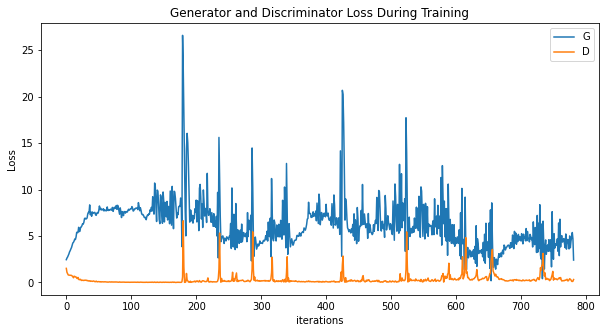

In [ ]:
plot_loss(G_losses, D_losses, save = False)

## G’s progression



In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

## Real Images vs. Fake Images




In [ ]:
def plot_realvsfake(dataloader, device, img_list, save = False):
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    if save == True:
        plt.savefig(PATH + 'img/real_vs_fake', format="png",dpi=400)
    plt.show()
    return

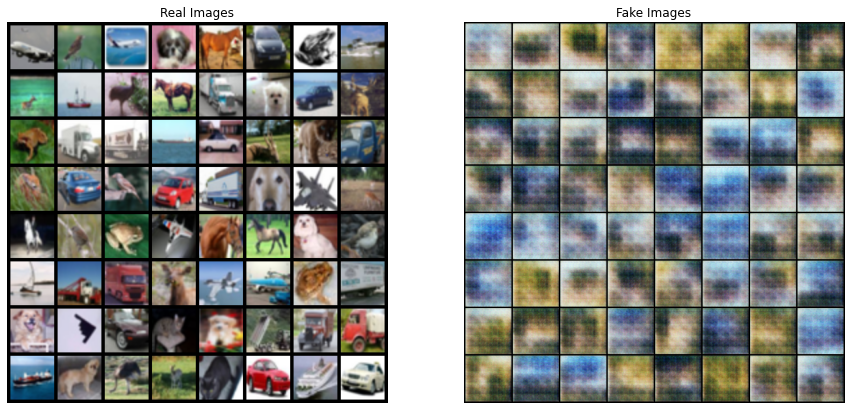

In [ ]:
plot_realvsfake(dataloader, device, img_list, save = False)

# Serialization

In [ ]:
# Paths to load and save the models
prefix = 'models/04_05_22_'

model_name_G = prefix +'model_G'
save_path_G = PATH + model_name_G

model_name_D = prefix +'model_D'
save_path_D = PATH + model_name_D

In [ ]:
# save the models
def save_models(netG ,netD, save_path_G, save_path_D):
    torch.save(netG.state_dict(), save_path_G)
    torch.save(netD.state_dict(), save_path_D)
    print('GAN saved')
    return

In [ ]:
save_models(netG ,netD, save_path_G, save_path_D)

GAN saved


In [ ]:
# load the models

def load_models(ngpu, Discriminator, Generator, save_path_G, save_path_D):

    netD = Discriminator(ngpu).to(device)
    netD.load_state_dict(torch.load(save_path_D))
    netD.eval()

    netG = Generator(ngpu).to(device)
    netG.load_state_dict(torch.load(save_path_G))
    netG.eval()
    
    print('GAN loaded')
    return netD, netG

In [ ]:
netD, netG = load_models(ngpu, Discriminator, Generator, save_path_G, save_path_D)

GAN loaded


In [ ]:
# todo: save the figures --> see every plot, figure is saved just before plt.show()

# Hyper-parameter optimization (gridsearch)

In [ ]:
def run_experiment(ngpu, device, real_label, fake_label, dataset, workers,
                   batch_size, shuffle, num_epochs, fixed_noise, plot = True):
    netG = init_netG(ngpu, device)
    netD = init_netD(ngpu, device)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

    stats = train(netD, netG, device, real_label, fake_label, dataloader, num_epochs, fixed_noise)

    if plot:
        plot_loss(G_losses, D_losses, save = False)
        plot_realvsfake(dataloader, device, img_list, save = False)
        
    return stats, dataloader, netG, netD

In [ ]:
def grid_search(ngpu, device, real_label, fake_label, dataset, workers,
                   batch_size_list, shuffle_list, num_epochs_list, fixed_noise_list, plot = True ):
    all_stats = [] 



    for batch_size in batch_size_list :
      for shuffle in shuffle_list :
        for num_epochs in num_epochs_list :
          for fixed_noise in fixed_noise_list :
              print('batch_size', batch_size, 'shuffle', shuffle, 'num_epochs', num_epochs)
              stats, dataloader, netG, netD = run_experiment(ngpu, device, real_label, fake_label, dataset, workers,
                            batch_size, shuffle, num_epochs, fixed_noise)
    
    all_stats.append(stats)

    return all_stats

In [ ]:
all_stats = grid_search(ngpu, device, real_label, fake_label, dataset, workers,
                        batch_size_list = [128, 64, 32, 16],
                        shuffle_list = [False, True],
                        num_epochs_list = [5, 10 , 20], # actually we don't need to iterate over this but I'm still putting here
                        fixed_noise_list = [ fixed_noise ], plot = True )

batch_size 128 shuffle False num_epochs 5
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

KeyboardInterrupt: ignored